# Simulating invasion percolation

In [1]:
try:
    import numpy as np
    assert np.__version__=='1.20.0',"Please note that this code is only tested on numpy 1.20"
    import openpnm as op
    import porespy as ps
    assert op.__version__ == '2.8.2',"Please note that this code is only tested on openpnm 2.8.2"
    from openpnm.network import GenericNetwork
    from openpnm.geometry import Imported
    from openpnm.io import GenericIO
    from openpnm.models import physics as mods
    import matplotlib.pyplot as plt
    import bz2
    import pickle
    import _pickle as cPickle
except:
    import sys
    !{sys.executable} -m pip install numpy==1.20.0 matplotlib==3.5.1 openpnm==2.8.2 porespy==1.3.1
    import openpnm as op
    from openpnm.network import GenericNetwork
    from openpnm.geometry import Imported
    from openpnm.io import GenericIO
    from openpnm.models import physics as mods
    import matplotlib.pyplot as plt
    import numpy as np
    import bz2
    import pickle
    import _pickle as cPickle

In [2]:
ws = op.Workspace()
ws.clear()
r_max = 5
sigma = 0.35
fname = 'Berea700_r'+str(r_max)+'_sigma'+str(int(sigma*100))

# old way of importing things
# =============================================================================
# import pickle as pk
# net = pk.load(open(fname + '.dict', 'rb'))
# pn = op.network.GenericNetwork()
# pn.update(net)
# geom = op.geometry.Imported(network=pn)
# prj = pn.project

# prj = op.io.PoreSpy.load(fname + '.dict')
# pn = prj.network
# geom = prj.geometries()['geo_01']

Load compressed pickle file

In [3]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data
data = decompress_pickle(fname+'.pbz2') 

network = GenericNetwork(project=None)
network = GenericIO._update_network(network=network, net=data)
Imported(network=network, settings={})
prj = network.project
pn = prj.network
geom = prj.geometries()['geo_01']

In [4]:
# trim isolated clusters
# =============================================================================

In [5]:
net_health = pn.check_network_health()
op.topotools.trim(network=pn, pores=net_health["trim_pores"])

In [6]:
# Plotting the network
# =============================================================================

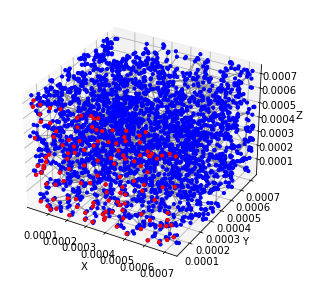

In [7]:
ax = op.topotools.plot_connections(network=pn, alpha=0.8, color='grey')
ax = op.topotools.plot_coordinates(network=pn, ax=ax, color='b', markersize=10)
ax = op.topotools.plot_coordinates(network=pn, pores=pn.pores('front'), ax=ax, color='r', markersize=10)

In [8]:
# Modifying pore network 
# =============================================================================

In [9]:
del geom['pore.area']
del geom['pore.volume']
del geom['throat.conduit_lengths.pore1']
del geom['throat.conduit_lengths.pore2']
del geom['throat.conduit_lengths.throat']
del geom['throat.endpoints.tail']
del geom['throat.endpoints.head']


geom['throat.volume'] = np.zeros(geom['throat.volume'].shape)
geom.add_model(propname='pore.volume',
                model=op.models.geometry.pore_volume.sphere)
geom['pore.volume'][pn.pores('boundary')] = 0
geom.add_model(propname='throat.endpoints',
                model=op.models.geometry.throat_endpoints.spherical_pores)
geom.add_model(propname='pore.area',
                model=op.models.geometry.pore_area.sphere)
geom.add_model(propname='throat.conduit_lengths',
                model=op.models.geometry.throat_length.conduit_lengths)

In [10]:
# defining the fluid
# =============================================================================

In [11]:
oil = op.phases.GenericPhase(network=pn)
oil['throat.contact_angle'] = 180 
oil['pore.contact_angle'] = 180
oil['throat.surface_tension'] = 20e-3
oil['pore.surface_tension'] = 20e-3

In [12]:
# defining the physics
# =============================================================================

In [13]:
phys = op.physics.GenericPhysics(network=pn, phase=oil, geometry=geom)
phys.add_model(propname='throat.entry_pressure',
                model=mods.capillary_pressure.washburn)
phys['pore.entry_pressure'] = 0

In [14]:
# performing invasion percolation
# =============================================================================

In [15]:
alg_ip = op.algorithms.InvasionPercolation(network=pn)
alg_ip.setup(phase=oil)
alg_ip.set_inlets(pores=pn.pores('left'))
alg_ip.run()
# alg_ip.apply_trapping(outlets=pn.pores(['right']))
data_ip = alg_ip.get_intrusion_data()

In [16]:
# Plotting percolation results
# =============================================================================

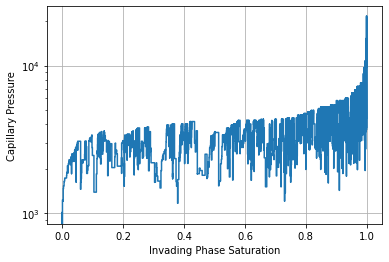

In [17]:
data_ip = alg_ip.get_intrusion_data()
fig, ax = plt.subplots()
ax.semilogy(data_ip.S_tot, data_ip.Pcap)
plt.xlabel('Invading Phase Saturation')
plt.ylabel('Capillary Pressure')
plt.grid(True)
plt.show()

In [18]:
# performing ordinary percolation
# =============================================================================
# alg_op = op.algorithms.OrdinaryPercolation(network=pn, phase=oil)
# alg_op.set_inlets(pn.pores('left'))
# alg_op.setup(pore_volume='pore.volume',
#              throat_volume='throat.volume')
# alg_op.run(points=1000)
# data_op = alg_op.get_intrusion_data()
# ax.semilogy(data_op.Snwp, data_op.Pcap, 'ko-', markersize=2)          

In [19]:
# have a look at invasion percolation sequence (paraview recommended for 3D)
# =============================================================================
# max_seq = alg_ip['pore.invasion_sequence'].max()
# seq = max_seq.max()
# fig = op.topotools.plot_connections(network=pn, alpha=0.8, color='grey')
# fig = op.topotools.plot_coordinates(network=pn, fig=fig, color='b', markersize=10)
# fig = op.topotools.plot_coordinates(network=pn, pores=alg_ip['pore.invasion_sequence'] < seq, fig=fig, color='r', markersize=10)
# fig.set_size_inches(8, 8)
# fig.tight_layout()

Save output for visualization

In [23]:
op.io.VTK.save(network=pn,filename=fname) 